# Laboratorio 2
Este laboratorio se divide dentro de 3 tasks diferentes. El primer task se encuentra dentro del archivo Informe.pdf, dónde se respondieron preguntas teóricas sobre diferentes modelos / algoritmos aplicados en situaciones de la vida real.

Para los siguientes dos tasks, primero debemos descargar un dataset y limpiar los datos. Luego, debemos implementar algoritmos de ML desde 0 para aplicarlos sobre los datos limpios.

## Task 2

### 1. Carga y Limpieza
Primero, vamos a utilizar Kagglehub para poder descargar el dataset. De esta manera, al correr el Notebook en algún otro dispositivo no debemos estar manejando la transferencia del archivo .csv

In [86]:
import kagglehub
import pandas as pd

# Download dataset and get path to directory
path = kagglehub.dataset_download("shashwatwork/web-page-phishing-detection-dataset")

# Read csv at path
df = pd.read_csv(f"{path}/dataset_phishing.csv")

# Show DF
df.head(20)

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,...,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.000000,0,0,0,0,0,3,0,0,0,0,0,0,...,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.000000,0,0,0,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.000000,0,0,0,0,0,1,0,0,0,0,1,0,...,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.000000,0,0,0,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.000000,0,0,0,1,0,3,1,0,0,0,1,0,...,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.000000,0,0,0,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0,0,0,0,0,2,0,0,0,0,1,0,...,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.500000,0,0,0,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.000000,0,0,0,0,0,2,0,0,0,0,1,0,...,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.000000,0,0,0,0,1,0,224,8175,8725,0,0,6,legitimate
5,http://appleid.apple.com-app.es/,32,24,0,3,1,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,1,0,0,1,0.000000,0.000000,0,0,0,0,0,3,1,0,0,0,1,0,...,4.5,0.000000,0,0,0,0,0,0,10,0.300000,0.700000,0,0,0,0.571429,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,0.000000,0,0,0,1,1,1,0,-1,0,0,1,0,phishing
6,http://www.mutuo.it,19,12,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.000000,0,0,0,0,0,2,0,0,0,0,1,0,...,4.0,0.000000,0,0,0,0,0,0,98,0.081633,0.918367,0,10,0,0.000000,0,0.000000,0,1,0.000000,0,0.000000,100.000000,0,0,0,100.000000,0,0,0,0,1,0,170,7529,0,0,0,1,legitimate
7,http://www.shadetreetechnology.com/V4/validati...,81,27,1,2,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.259259,0.000000,0,0,0,0,0,2,0,0,0,0,1,0,...,11.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.000000,0,0,0,1,0,0,76,5767,0,0,1,2,phishing
8,http://vamoaestudiarmedicina.blogspot.com/,42,34,0,2,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0,0,0,0,0,2,0,0,1,0,0,0,...,14.5,0.000000,0,1,0,0,0,0,63,0.206349,0.793651,0,3,0,0.380000,0,0.000000,0,1,0.000000,0,0.000000,100.000000,0,0,0,27.272727,0,0,0,1,1,0,371,7298,0,0,0,5,legitimate
9,https://parade.com/425836/joshwigler/the-amazi...,104,10,0,1,10,0,0,0,0,0,0,0,0,6,0,1,0,0,0,0,0,0,0,0,0,0.076923,0.000000,0,0,0,0,0,1,0,0,0,0,0,0,...,6.0,5.538462,1,0,0,0,0,0,140,0.778571,0.221429,0,1,0,0.193548,0,0.000000,0,1

Luego de haber cargado exitosamente el dataset, lo primero que podemos observar es que tenemos 89 columnas. Sería ideal si tuviéramos alguna documentación sobre el significado de cada una, sin embargo, la descripción oficial del dataset es la siguiente:

"The provided dataset includes 11430 URLs with 87 extracted features. The dataset is designed to be used as benchmarks for machine learning-based phishing detection systems. Features are from three different classes: 56 extracted from the structure and syntax of URLs, 24 extracted from the content of their correspondent pages, and 7 are extracted by querying external services. The dataset is balanced, it contains exactly 50% phishing and 50% legitimate URLs."

Para el scope de este laboratorio, únicamente debemos indagar sobre las variables más correlacionadas con la variable objetivo. Por lo tanto, vamos a iniciar encodeando la variable objetivo.

In [87]:
# Map text labels to binary representation
df['status'] = df['status'].map({'phishing': 1, 'legitimate': 0})

status_counts = df['status'].value_counts().reset_index()

status_counts.columns = ['Status Label', 'Total Count']

# Sanity check
status_counts

,Status Label,Total Count
0,0,5715
1,1,5715


Estos valores concuerdan con la descripción, dónde el dataset se encuentra perfectamente balanceado.

Ahora, podemos remover la columna de url, ya que tenemos una gran cantidad de atributos derivados numéricos. Luego, podemos identificar que columnas no tienen tipos de datos numéricos en el dataset restante.

In [88]:
# Drop URL col
df = df.drop(columns=['url'])

# List non-numeric cols
no_num = df.select_dtypes(exclude=['number']).columns.tolist()

# Print list
print("Columnas no numéricas:")
print(no_num)

Columnas no numéricas:
[]


### 2. Selección de Features

Luego de verificar que todas las columnas sean numéricas, podemos calcular la correlación con la variable objetivo.

In [89]:
# Top 5 most correlated features with respect to target variable
top = df.corr()['status'].abs().sort_values(ascending=False)[1:6]

# Show / make DF
top.to_frame('Correlation')

,Correlation
google_index,0.731171
page_rank,0.511137
nb_www,0.443468
ratio_digits_url,0.356395
domain_in_title,0.342807


Podemos ver que las dos variables más correlacionadas claramente son `google_index` y `page_rank`, por lo cuál serán las variables con las que trabajaremos. Podemos seleccionar unicamente las variables que nos interesan del DF.

##

In [90]:
# Filter DF columns
df = df[['google_index', 'page_rank','status']]

# Show DF
df.head(10)

,google_index,page_rank,status
0,1,4,0
1,1,2,1
2,1,0,1
3,0,3,0
4,0,6,0
5,1,0,1
6,0,1,0
7,1,2,1
8,0,5,0
9,0,5,0


### 3. Split Test / Train
En el laboratorio se encuentran en otro orden los incisos, sin embargo si escalamos las variables antes de realizar la division tendriamos data leakage. Vamos a realizar un split estratificado respecto a la variable objetivo, 80/20 train/test.

In [91]:
from sklearn.model_selection import train_test_split

x = df.drop('status', axis=1)
y = df['status']

# Split 80/20 with stratification
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.20, 
    random_state=42,
    stratify=y
)

In [92]:
x_train

,google_index,page_rank
7609,1,6
6408,1,0
7464,1,3
9286,1,7
5159,1,3
...,...,...
8364,0,5
9876,1,0
4943,1,5
9054,1,0


x_train

### 4. Feature Scaling
Antes de escalar los features, nos interesa saber la distribucion de los datos. Antes que nada, debemos de buscar los posibles valores de cada una de nuestras variables:

In [93]:
print('Google Index unique values')
print(df['google_index'].unique())

print('Page rank unique values')
print(f"Sample values: {df['page_rank'].unique()}")

Google Index unique values
[1 0]
Page rank unique values
Sample values: [ 4  2  0  3  6  1  5  7  8 10  9]


Podemos ver que Google Index corresponde a una clasificacion binaria, entonces podemos proceder a examinar la distribucion de Page Rank

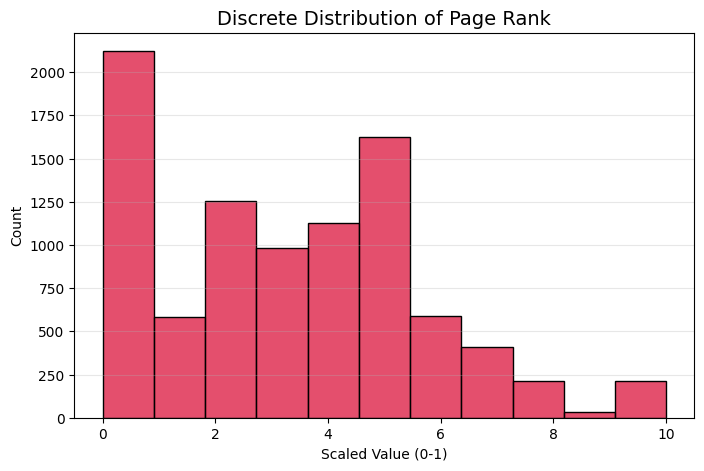

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

sns.histplot(x=x_train['page_rank'], color='crimson', bins=11, kde=False)

plt.title('Discrete Distribution of Page Rank', fontsize=14)
plt.xlabel('Scaled Value (0-1)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.show()

Claramente, la distribucion no parece seguir una distribucion normal. De hecho, pareciera seguir una distribucion multimodal (lo cual tiene sentido, ya que esta correlacionada con la variable objetivo). Esto nos indica que la mejor opcion para utilizar el MinMax Scaler, ademas tenemos la ventaja que nuestro otro feature ya se encuentra en el rango [0,1].

Adicionalmente, podemos observar en la distribucion que tenemos una cola bastante larga hacia la derecha. Podemos examinar algunos de estos valores mas a detalle, buscando que los valores atipicos en la cola derecha no 'apachen' o 'estiren' nuestros datos

In [95]:
import pandas as pd

high_percentiles = [.9, .95, .96, .97, .98, .99]

stats_df = x_train[['page_rank']].describe(percentiles=high_percentiles).T

cols_to_show = ['90%', '95%', '96%', '97%', '98%', '99%', 'max']
stats_df = stats_df[cols_to_show]

# Display the DF
stats_df

,90%,95%,96%,97%,98%,99%,max
page_rank,6.0,7.0,8.0,8.0,10.0,10.0,10.0


Podemos ver que los datos por encima de 8 empiezan a 'aplanarse' un poco respecto al percentil, ademas representan una fraccion relativamente pequeña de neustros datos. Por lo tanto, podemos poner un 'cap' a los datos con valores encima de 8. Adicionalmente, aplicamos nuestro MinMaxScaler().

In [96]:
from sklearn.preprocessing import MinMaxScaler

# Clip values above 8 down to 9
x_train['page_rank'], x_test['page_rank'] = x_train['page_rank'].clip(upper=8.0), x_test['page_rank'].clip(upper=8.0)

# Initialize Scaler
scaler = MinMaxScaler()

# Scale using fit_transform for train and transform for test
x_train['page_rank'] = scaler.fit_transform(x_train[['page_rank']])
x_test['page_rank'] = scaler.transform(x_test[['page_rank']])

Ahora, podemos ver nuestra nueva distribucion generando la gráfica original nuevamente.

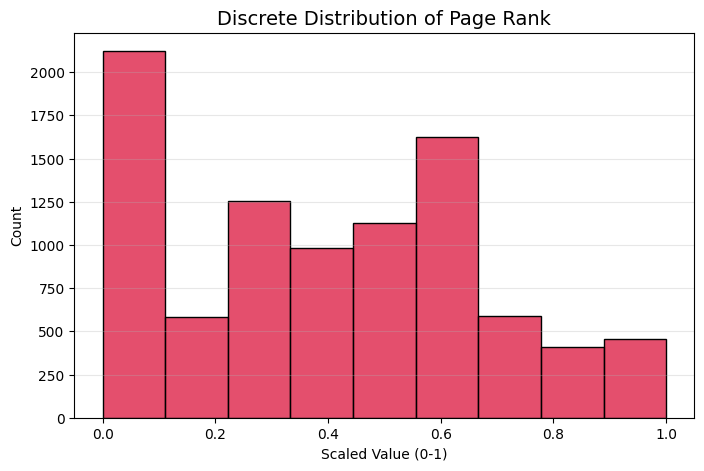

In [97]:
plt.figure(figsize=(8, 5))

sns.histplot(x=x_train['page_rank'], color='crimson', bins=9, kde=False)

plt.title('Discrete Distribution of Page Rank', fontsize=14)
plt.xlabel('Scaled Value (0-1)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.show()

Ya que ahora tenemos los valores escalados en el intervalo necesario y realizamos ajustes a los valores máximos, tenemos nuestro dataset listo para modelar.

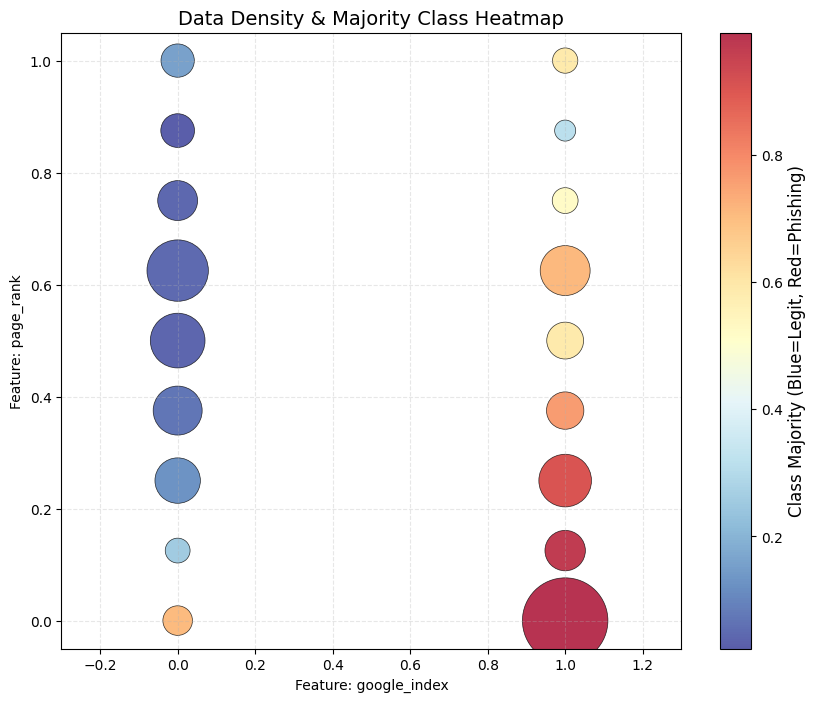

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Combine features and target to find the "piles"
# Using .iloc to avoid your previous KeyError
plot_df = x_train.iloc[:, [0, 1]].copy()
plot_df['target'] = y_train.values
cols = plot_df.columns

# 2. Group by coordinates to calculate stats for each pile
# 'count' = how many points (size)
# 'mean' = the majority class (color/heatmap)
piles = plot_df.groupby([cols[0], cols[1]])['target'].agg(['count', 'mean']).reset_index()

# 3. Plotting
plt.figure(figsize=(10, 8))

# s: Size of bubble (we scale 'count' so it's visible)
# c: Color based on the mean (0.0 to 1.0)
scatter = plt.scatter(piles.iloc[:, 0], 
                      piles.iloc[:, 1], 
                      s=piles['count'] * 2,  # Adjust the '2' if bubbles are too small/big
                      c=piles['mean'], 
                      cmap='RdYlBu_r',      # Red for Phishing, Blue for Legit
                      alpha=0.8, 
                      edgecolors='k', 
                      linewidth=0.5)

# Add colorbar to explain the "heatmap" colors
cb = plt.colorbar(scatter)
cb.set_label('Class Majority (Blue=Legit, Red=Phishing)', fontsize=12)

plt.title("Data Density & Majority Class Heatmap", fontsize=14)
plt.xlabel(f"Feature: {cols[0]}")
plt.ylabel(f"Feature: {cols[1]}")

# Fix the "stretched" X-axis look for binary data
plt.xlim(plot_df.iloc[:, 0].min() - 0.3, plot_df.iloc[:, 0].max() + 0.3)
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

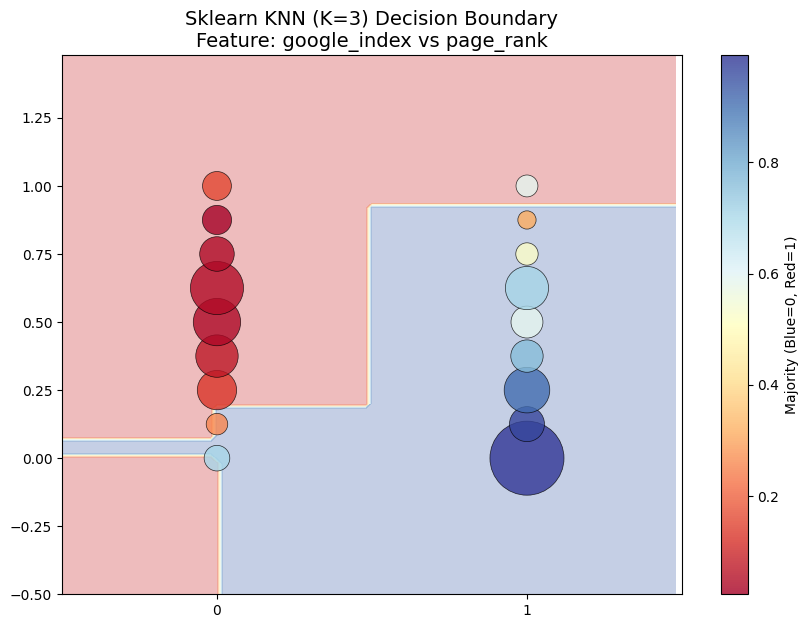

In [190]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# 1. Select your 2 features for visualization
# Feature 0 (page_rank) and Feature 1 (continuous)
# Shuffling in-place to randomize tie-breaking order
indices = np.arange(len(x_train))
np.random.shuffle(indices)

# Re-assigning with the shuffled order
X_vis = x_train.iloc[indices, [0, 1]].values
y_vis = y_train.values[indices]

# 2. Initialize and Fit Sklearn KNN
# Using a higher K to smooth out the "weird" jagged lines caused by overlaps
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_vis, y_vis)

# 3. Create the Grid (The "Territory Map")
h = 0.02  # Step size of the mesh
x_min, x_max = X_vis[:, 0].min() - 0.5, X_vis[:, 0].max() + 0.5
y_min, y_max = X_vis[:, 1].min() - 0.5, X_vis[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# 4. Predict over the whole grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 5. Plotting
plt.figure(figsize=(10, 7))

# The Decision Boundary Background
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')

# The "Truth" - Plotting the actual piles
# Since standard scatter lies, we use the "Bubble" approach from earlier
unique_pts = x_train.iloc[:, [0, 1]].copy()
unique_pts['target'] = y_train.values
counts = unique_pts.groupby([unique_pts.columns[0], unique_pts.columns[1]])['target'].agg(['count', 'mean']).reset_index()

scatter = plt.scatter(counts.iloc[:, 0], 
                      counts.iloc[:, 1], 
                      s=counts['count'] * 1.5, # Size shows the "bajillion"
                      c=counts['mean'],        # Color shows the pile majority
                      cmap='RdYlBu', 
                      edgecolors='k', 
                      linewidth=0.5, 
                      alpha=0.8)

# Formatting
plt.title(f"Sklearn KNN (K=3) Decision Boundary\nFeature: {x_train.columns[0]} vs {x_train.columns[1]}", fontsize=14)
plt.colorbar(scatter, label='Majority (Blue=0, Red=1)')
plt.xlim(-0.5, 1.5)
plt.xticks([0, 1])
plt.show()